## This file demonstrates how to create a randomised geometry with an Upgrade-like instrumentation density.

In [2]:
import sys
import os
os.environ["CUDA VISIBLE DEVICES"]="4"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.set_printoptions(threshold=sys.maxsize)
from scipy import stats
from sklearn.model_selection import train_test_split
import math
import plotly.graph_objs as go
from scipy.optimize import minimize

# New Fancy Geometry with randomised sensor positons

## 1. First position strings and remove clustering

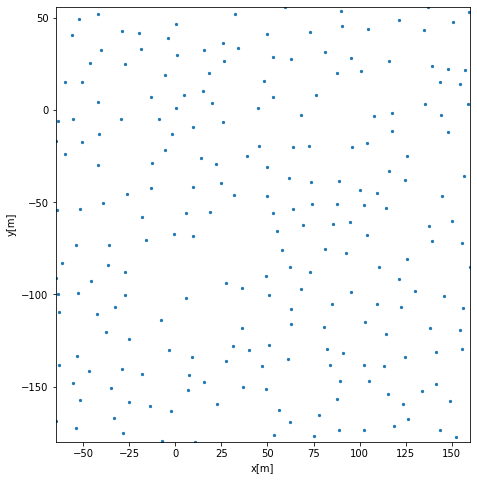

Mean minimum distance between closest neighbors: 10.74 meters


In [3]:
# Set the desired density (points per unit area)
density = 500 / ((160+65)*(180+56))

# Set the bounds of the plane
x_min, x_max = -65, 160
y_min, y_max = -180, 56

# Calculate the total area of the plane
total_area = (x_max - x_min) * (y_max - y_min)

# Calculate the number of points to generate
num_points = np.random.poisson(total_area * density)

# Generate the random points
loc_x = np.random.uniform(x_min, x_max, size=num_points)
loc_y = np.random.uniform(y_min, y_max, size=num_points)

# Check for clustering and remove points that are too close
while True:
    # Calculate the distances between all pairs of points
    dists = np.sqrt((loc_x[:, np.newaxis] - loc_x[np.newaxis, :])**2
                    + (loc_y[:, np.newaxis] - loc_y[np.newaxis, :])**2)
    # Set the diagonal to infinity so that each point isn't compared with itself
    np.fill_diagonal(dists, np.inf)
    # Find the indices of points that are too close
    too_close = np.argwhere(dists < 8)
    if too_close.size == 0:
        # No points are too close, so break the loop
        break
    else:
        # Remove the first point that is too close to another point
        loc_x = np.delete(loc_x, too_close[0, 0])
        loc_y = np.delete(loc_y, too_close[0, 0])
        
        
# Remove points that are too far from their closest neighbor
while True:
    # Calculate the distances between all pairs of points
    distances = np.sqrt((loc_x[:, np.newaxis] - loc_x[np.newaxis, :])**2
                        + (loc_y[:, np.newaxis] - loc_y[np.newaxis, :])**2)
    # Set the diagonal to infinity so that each point isn't compared with itself
    np.fill_diagonal(distances, np.inf)
    # Find the indices of points that are too far from their closest neighbor
    too_far = np.argwhere(np.min(distances, axis=1) > 20)
    if too_far.size == 0:
        # No points are too far, so break the loop
        break
    else:
        # Remove the first point that is too far from its closest neighbor
        loc_x = np.delete(loc_x, too_far[0, 0])
        loc_y = np.delete(loc_y, too_far[0, 0])


# Plot the remaining points
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(loc_x, loc_y, s=5)
ax.set_xlabel("x[m]")
ax.set_ylabel("y[m]")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
plt.show()

# Calculate the pairwise distances between all points
distances = np.sqrt((loc_x[:, np.newaxis] - loc_x)**2 + (loc_y[:, np.newaxis] - loc_y)**2)

# Set the diagonal to infinity so that we don't consider distances to ourselves
np.fill_diagonal(distances, np.inf)

# Find the minimum distance between each point and its closest neighbor
min_distances = np.min(distances, axis=1)

# Calculate the mean of the minimum distances
mean_min_distance = np.mean(min_distances)

print(f"Mean minimum distance between closest neighbors: {mean_min_distance:.2f} meters")


In [4]:
strings=len(loc_x)
print(strings)

229


## 2. Then position modules within a string

In [7]:
VecStart_z_upgrade = [-2150,-2150,-2150,-2150,-2150,-2150,-2150] #In IceCube global coordinates in m.

ver_spacing=10
dom_count=80
loc_x_new=[]
#loc_x_temp=list(np.concatenate(loc_x).flat)
for i in range(len(loc_x)):
    for j in range(dom_count):
        loc_x_new.append(loc_x[i])

loc_y_new=[]
#loc_y_temp=list(np.concatenate(loc_y).flat)
for i in range(len(loc_y)):
    for j in range(dom_count):
        loc_y_new.append(loc_y[i])

loc_z=[]
for i in range(0,len(loc_x)):
    depth=VecStart_z_upgrade[0]+200
    for j in range(dom_count):
        loc_z.append(depth-np.abs(np.random.uniform(ver_spacing-5,ver_spacing+5)))
        depth=loc_z[-1]
        
loc_y=loc_y_new
loc_x=loc_x_new

## 3. Then remove clustering within a string.

In [9]:
num_strings=229
# Define the threshold for clustering
cluster_threshold = 8.0

# Create a new empty list to store the indices of sensors to remove
indices_to_remove = []

# Loop over all strings
for i in range(num_strings):
    # Loop over all sensors on the string
    for j in range(dom_count):
        # Loop over all other sensors on the same string
        for k in range(j+1, dom_count):
            # Calculate the Euclidean distance between the sensors
            dist = np.sqrt((loc_x[i*dom_count+j]-loc_x[i*dom_count+k])**2 +
                           (loc_y[i*dom_count+j]-loc_y[i*dom_count+k])**2 +
                           (loc_z[i*dom_count+j]-loc_z[i*dom_count+k])**2)
            # Check if the distance is below the clustering threshold
            if dist < cluster_threshold:
                # Mark the sensors to remove
                indices_to_remove.extend([i*dom_count+j, i*dom_count+k])

# Remove the marked sensors
loc_x = np.delete(loc_x, indices_to_remove)
loc_y = np.delete(loc_y, indices_to_remove)
loc_z = np.delete(loc_z, indices_to_remove)

## 4. Save in a file

In [ ]:
geo_file = open("geo-f2k_hrand_vrand",'w+')
sensor_count = 0

# Create a mask to remove indices that are deleted
mask = np.ones(strings*dom_count, dtype=bool)
mask[indices_to_remove] = False

for i in range(strings):
    for j in range(dom_count):
        if not mask[(i*dom_count)+j]:
            continue
        geo_file.write('554-0000'+"\t"+"0x074893086002"+"\t"+"%.2f"%loc_x[sensor_count]+"\t"+"%.2f"%loc_y[sensor_count]+"\t"+"%.2f"%loc_z[sensor_count]+"\t"+str(i)+"\t"+str(j)+"\n")
        sensor_count += 1
geo_file.close()

## 5. Make sure that the indices are continuous in the geo-f2k file

In [ ]:
geo_file = open("geo-f2k_hrand_vrand", 'r')
lines = geo_file.readlines()
geo_file.close()

# Create a mask to remove indices that are deleted
mask = np.ones(strings*dom_count, dtype=bool)
mask[indices_to_remove] = False

# Create a mapping of old indices to new indices
index_map = {}
new_index = 0
for i in range(strings):
    for j in range(dom_count):
        if mask[(i*dom_count)+j]:
            index_map[(i, j)] = new_index
            new_index += 1

# Update the file with new indices
geo_file = open("geo-f2k_hrand_vrand", 'w')
for line in lines:
    fields = line.strip().split('\t')
    string_index, dom_index = int(fields[-2]), int(fields[-1])
    new_string_index, new_dom_index = index_map[(string_index, dom_index)]
    fields[-2], fields[-1] = str(new_string_index), str(new_dom_index)
    geo_file.write('\t'.join(fields) + '\n')
geo_file.close()


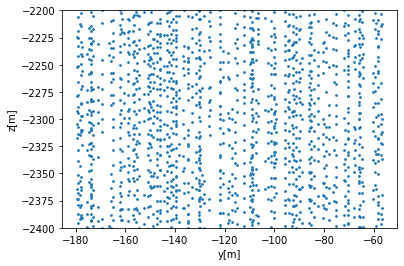

In [14]:
dom_pos=pd.read_csv("geo-f2k_hrand_vrand",sep='\t',header=None)

# filter the rows based on the condition
dom_pos_filtered = dom_pos[(dom_pos.loc[:,3] <= -55) & (dom_pos.loc[:,2] >= -60)]

# plot only the filtered rows
plt.scatter(dom_pos_filtered.loc[:][3], dom_pos_filtered.loc[:][4], s=3)
plt.xlabel('y[m]')
plt.ylabel('z[m]')
plt.ylim(-2400,-2200)

plt.show()

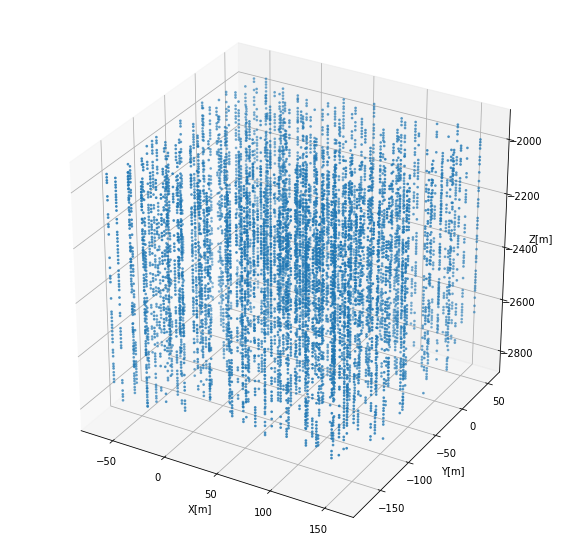

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(loc_x, loc_y, loc_z, s=3)

ax.set_xlabel('X[m]')
ax.set_ylabel('Y[m]')
ax.set_zlabel('Z[m]')

plt.show()